In [19]:
import pandas as pd
data = pd.read_csv('bbc_cleaned.csv')

In [20]:
data['topic_id'] = data['topic'].factorize()[0]
topic_id_df = data[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

print(topic_id_df)
print(topic_to_id)
print(id_to_topic)  

            topic  topic_id
0           sport         0
1        politics         1
2            tech         2
5        business         3
18  entertainment         4
{'sport': 0, 'politics': 1, 'tech': 2, 'business': 3, 'entertainment': 4}
{0: 'sport', 1: 'politics', 2: 'tech', 3: 'business', 4: 'entertainment'}


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.text).toarray()
labels = data.topic_id
print(features.shape) 

(2118, 12542)


In [22]:
from sklearn.feature_selection import chi2
import numpy as np

N = 3
for topic, topic_id in sorted(topic_to_id.items()):
  features_chi2 = chi2(features, labels == topic_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(topic))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . bank
  . Most correlated bigrams:
       . economic growth
       . stock market
       . analysts say
# 'entertainment':
  . Most correlated unigrams:
       . star
       . award
       . film
  . Most correlated bigrams:
       . film festival
       . win best
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . general election
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . champion league
       . australian open
       . grand slam
# 'tech':
  . Most correlated unigrams:
       . software
       . technology
       . users
  . Most correlated bigrams:
       . people use
       . let people
       . mobile phone


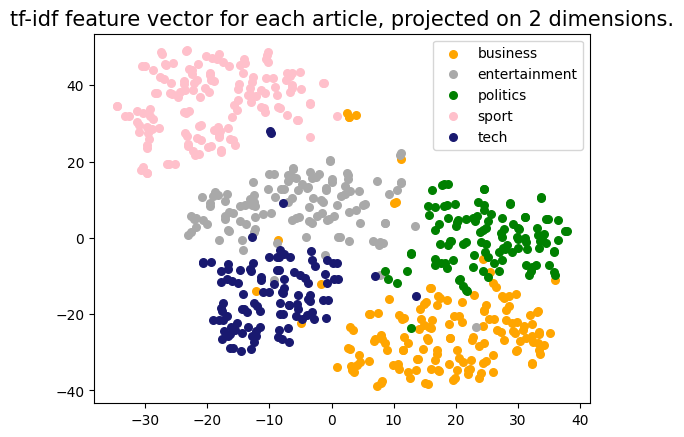

(635, 2)
(2118, 12542)


In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

topic_id_df = data[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)

# Adjusted random_state to 42
projected_features = TSNE(n_components=2, random_state=42).fit_transform(features[indices])

colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for topic, topic_id in sorted(topic_to_id.items()):
    points = projected_features[(labels[indices] == topic_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[topic_id], label=topic)

plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()
plt.show()

print(projected_features.shape)
print(features.shape)


In [24]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC  # Import SVM
# from sklearn.model_selection import cross_val_score
# import seaborn as sns


# # Khởi tạo các mô hình
# models = [
#     RandomForestClassifier(random_state=42),
#     LogisticRegression(random_state=42),
#     SVC(kernel='linear', random_state=42)
# ]

# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []

# # Thực hiện đánh giá chéo
# for model in models:
#     model_name = model.__class__.__name__
#     accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#     for fold_idx, accuracy in enumerate(accuracies):
#         entries.append((model_name, fold_idx, accuracy))

# # Tạo DataFrame từ các kết quả
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [25]:
# palette = {'RandomForestClassifier': 'red', 'LogisticRegression': 'green', 'SVC': 'blue'}

# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2,palette=palette)
# cv_df.groupby('model_name').accuracy.mean()

In [26]:
from sklearn.model_selection import train_test_split

texts = data['text']  
labels = data['topic']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

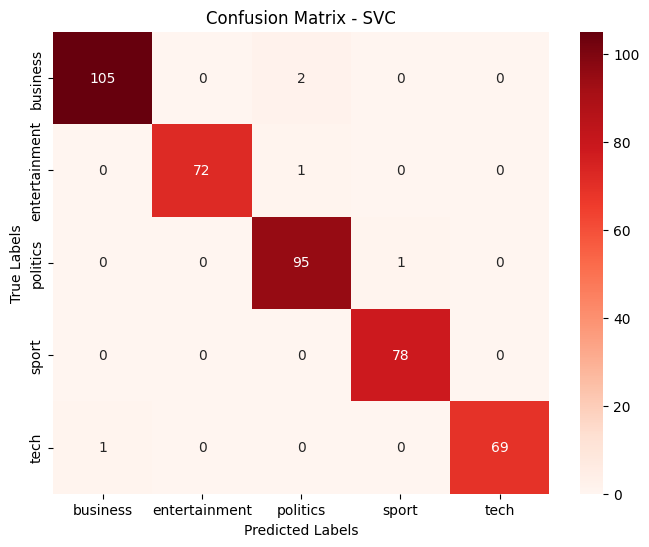

        Actual Predicted
1565     sport     sport
1100     sport     sport
1329     sport     sport
1261      tech      tech
637   business  business
...        ...       ...
581   politics  politics
2083     sport     sport
351   business  business
1815  business  business
1651  business  business

[424 rows x 2 columns]
SVC Classification Report:
               precision    recall  f1-score   support

     business       0.99      0.98      0.99       107
entertainment       1.00      0.99      0.99        73
     politics       0.97      0.99      0.98        96
        sport       0.99      1.00      0.99        78
         tech       1.00      0.99      0.99        70

     accuracy                           0.99       424
    macro avg       0.99      0.99      0.99       424
 weighted avg       0.99      0.99      0.99       424



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.svm import SVC
X_train_tfidf = tfidf.fit_transform(X_train)  
X_test_tfidf = tfidf.transform(X_test) 

# Huấn luyện mô hình SVC
svc_clf = SVC(kernel='linear', random_state=42) 
svc_clf.fit(X_train_tfidf, y_train)

# Dự đoán trên tập kiểm tra
y_pred_svc = svc_clf.predict(X_test_tfidf)

# Tạo ma trận nhầm lẫn
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Reds', xticklabels=svc_clf.classes_, yticklabels=svc_clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVC')
plt.show()

# Tạo DataFrame chứa kết quả
svc_pred_df = pd.DataFrame()
svc_pred_df["Actual"] = y_test
svc_pred_df["Predicted"] = y_pred_svc

print(svc_pred_df)

# In báo cáo phân loại
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svc))

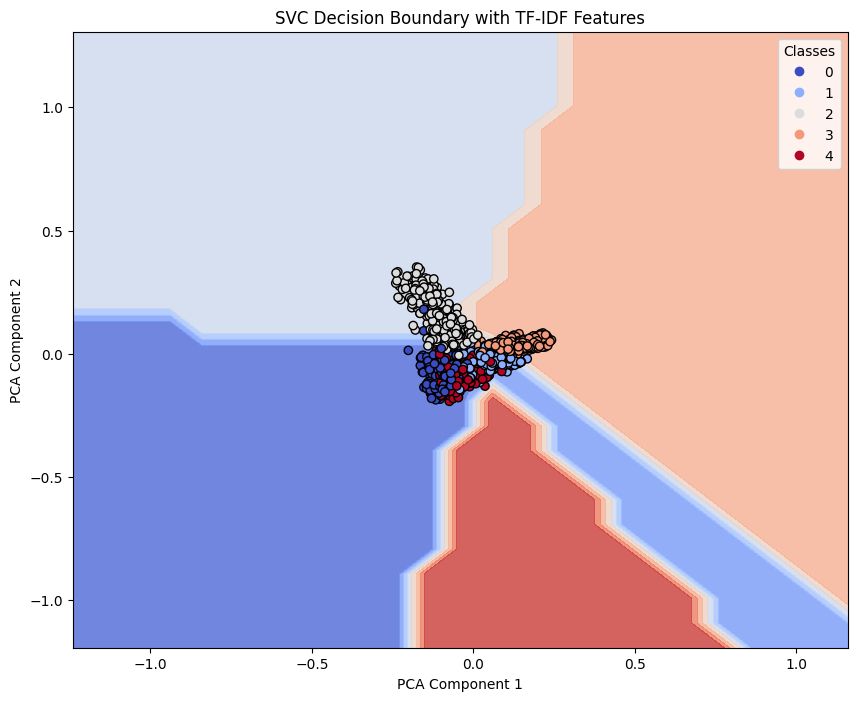

In [28]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Encode labels into numeric format (if not already numeric)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_test)
X_train_tfidf = tfidf.fit_transform(X_train)  
X_test_tfidf = tfidf.transform(X_test) 

# Reduce TF-IDF data to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_pca = pca.transform(X_test_tfidf.toarray())

# Train the SVC model with reduced dimensions
svc_clf = SVC(kernel='linear', random_state=42)
svc_clf.fit(X_train_pca, y_train_encoded)

# Create a meshgrid for decision boundary visualization
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict over the grid
Z = svc_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

# Scatter plot of the training points
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap=plt.cm.coolwarm, edgecolor='k')

# Add labels, title, and legend
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SVC Decision Boundary with TF-IDF Features")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()
